In [1]:
# find MovieLense 20M dataset on kaggle
# download rating.csv

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import lil_matrix , csr_matrix , save_npz , load_npz
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow.keras.backend as K



<h2>Preprocessing<h2>

In [ ]:
df = pd.read_csv('rating.csv')

In [ ]:
df.head(3)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


In [ ]:
# IDs from 1 , we need to get them to start from 0
# thankfully no missing number in between
df.userId -= 1 

In [ ]:
# movie ids from 1 with missing number in between
# make user id go from 0 - N-1 ,
# not all movies have ids
# this takes some time
movie_ids = set(df.movieId.values)
movie2idx = {k:v for v,k in enumerate(movie_ids)}
df['movie_idx'] = df.apply(lambda row: movie2idx[row.movieId] , axis = 1)


In [ ]:
# drop unecessary timestamp col
df = df.drop(columns=['timestamp'])

In [ ]:
# since that took some time lets save
df.to_csv('rating_1.csv')

<h2>to sparse matrix</h2>

In [50]:
df = pd.read_csv('rating_1.csv')

In [58]:
N = df.userId.max() + 1
M = df.movie_idx.max() + 1

df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [60]:
A = lil_matrix((N,M))
count = 0

def update_train(row): # populate A
  global count
  count+=1
  if count % 100000 == 0:
    print('processed %.3f ' %(float(count)/cutoff))
  i = int(row.userId)
  j = int(row.movie_idx)
  A[i,j] = row.rating

df_train.apply(update_train,axis = 1)

processed 0.006 %
processed 0.012 %
processed 0.019 %
processed 0.025 %
processed 0.031 %
processed 0.037 %
processed 0.044 %
processed 0.050 %
processed 0.056 %
processed 0.062 %
processed 0.069 %
processed 0.075 %
processed 0.081 %
processed 0.087 %
processed 0.094 %
processed 0.100 %
processed 0.106 %
processed 0.112 %
processed 0.119 %
processed 0.125 %
processed 0.131 %
processed 0.137 %
processed 0.144 %
processed 0.150 %
processed 0.156 %
processed 0.162 %
processed 0.169 %
processed 0.175 %
processed 0.181 %
processed 0.187 %
processed 0.194 %
processed 0.200 %
processed 0.206 %
processed 0.212 %
processed 0.219 %
processed 0.225 %
processed 0.231 %
processed 0.237 %
processed 0.244 %
processed 0.250 %
processed 0.256 %
processed 0.262 %
processed 0.269 %
processed 0.275 %
processed 0.281 %
processed 0.287 %
processed 0.294 %
processed 0.300 %
processed 0.306 %
processed 0.312 %
processed 0.319 %
processed 0.325 %
processed 0.331 %
processed 0.337 %
processed 0.344 %
processed 

8865754     None
13013959    None
10923187    None
9580520     None
15561425    None
            ... 
3538584     None
17995881    None
4553591     None
15304217    None
12271739    None
Length: 16000210, dtype: object

In [61]:
A = A.tocsr() # csr format is better for saving
save_npz('Atrain.npz',A)

In [64]:
A_test = lil_matrix((N,M))
count = 0

def update_test(row): # populate A_test
  global count
  count+=1
  if count % 100000 == 0:
    print('processed %.3f ' %(float(count)/len(df_test)))
  i = int(row.userId)
  j = int(row.movie_idx)
  A_test[i,j] = row.rating

df_test.apply(update_test,axis = 1)

processed 0.025 
processed 0.050 
processed 0.075 
processed 0.100 
processed 0.125 
processed 0.150 
processed 0.175 
processed 0.200 
processed 0.225 
processed 0.250 
processed 0.275 
processed 0.300 
processed 0.325 
processed 0.350 
processed 0.375 
processed 0.400 
processed 0.425 
processed 0.450 
processed 0.475 
processed 0.500 
processed 0.525 
processed 0.550 
processed 0.575 
processed 0.600 
processed 0.625 
processed 0.650 
processed 0.675 
processed 0.700 
processed 0.725 
processed 0.750 
processed 0.775 
processed 0.800 
processed 0.825 
processed 0.850 
processed 0.875 
processed 0.900 
processed 0.925 
processed 0.950 
processed 0.975 
processed 1.000 


14286169    None
2438494     None
18884222    None
9829131     None
9059611     None
            ... 
9686193     None
2980963     None
13443497    None
18391219    None
4859194     None
Length: 4000053, dtype: object

In [65]:
A_test = A_test.tocsr() 
save_npz('Atest.npz',A_test)

<h2>Autorec</h2>

In [30]:
batch_size = 128
epochs = 10
reg = 1e-4

In [31]:
A = load_npz('Atrain.npz')
A_test = load_npz('Atest.npz')

In [32]:
# we need mask so unknown ratings' loss are not included in total loss
mask = (A>0) * 1.0 # turn from T/F to 1/0 , all rating are between 0.5 and 5
mask_test = (A_test > 0) * 1.0

In [33]:
# make copies since we will shuffle train data in generator
# both matricies A and A_test are (N,D) , its important that each user occupies same row in both matriceies
# so take copies to use during test time

A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()
 

In [34]:
mu = A.sum() / mask.sum() # get mean of known ratings

In [35]:
print(mu)

3.5258639417857642


In [36]:
N,M = A.shape

In [37]:
# model
i = Input(shape=(M,))
x = Dropout(0.7)(i) # teach NN to predict missing rating not just construct new ones
x = Dense(700,activation='tanh',kernel_regularizer = l2(reg))(x)
x = Dense(M,kernel_regularizer = l2(reg))(x)

In [38]:
def custom_loss(y_true,y_pred): # keras' mse takes into account unknown ratings , so we need to make our own
  mask = K.not_equal(y_true,0)
  mask = K.cast(mask,dtype='float32')
  diff = y_pred -  y_true
  sqdiff = diff*diff*mask # get loses for only know ratings
  sse = K.sum(sqdiff) # safe to over all items since unknows items have ratings 0
  n = K.sum(mask) # number of items of known ratings
  return sse / n


In [39]:
def generator(A,M):
  while True:
    A,M = shuffle(A,M)
    for i in range(A.shape[0] // batch_size + 1):
      lower = i*batch_size
      upper = min(lower+batch_size,A.shape[0]) # last batch may be smaller than batch_size
      a = A[lower:upper].toarray() 
      m = M[lower:upper].toarray() # mask
      a = a - mu * m 
      # luckily mu is not an integer or exactly .5 thus no danger of some rating going to 0 and not included in cost
      # also we dont want to subtract mu from unknown rating or else they become - mu and enter into cost , so we multiply by m
      yield a,a

In [40]:
# we want auto enc to predict test data from train data
# if we pass in the test data that would be cheating since model will just output the input
def test_generator(A,M,A_test,M_test): 
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      lower = i*batch_size
      upper = min(lower+batch_size,A.shape[0]) # last batch may be smaller than batch_size
      a = A[lower:upper].toarray() 
      m = M[lower:upper].toarray() # mask
      at = A_test[lower:upper].toarray()
      mt = M_test[lower:upper].toarray()
      a = a - mu * m 
      at = at - mu * mt
      yield a,at

In [41]:
model = Model(i,x)
model.compile(loss = custom_loss,optimizer=SGD(lr=0.08,momentum=0.9),metrics=[custom_loss])

In [42]:
r = model.fit_generator(
    generator(A,mask),
    validation_data=test_generator(A_copy,mask_copy,A_test_copy,mask_test_copy),
    epochs = epochs,
    steps_per_epoch = A.shape[0] // batch_size + 1,
    validation_steps = A_test.shape[0] // batch_size +1
)
# keras reports regularised loss , so loss = mse (which is the custom_loss) _ l2 penatly

Epoch 1/10
1082/1082 [==============================] - 288s 266ms/step - loss: 0.9871 - custom_loss: 0.7476 - val_loss: 0.9172 - val_custom_loss: 0.7080
Epoch 2/10
1082/1082 [==============================] - 289s 267ms/step - loss: 0.8315 - custom_loss: 0.6461 - val_loss: 0.8503 - val_custom_loss: 0.6863
Epoch 3/10
1082/1082 [==============================] - 296s 274ms/step - loss: 0.7686 - custom_loss: 0.6211 - val_loss: 0.8094 - val_custom_loss: 0.6768
Epoch 4/10
1082/1082 [==============================] - 363s 336ms/step - loss: 0.7283 - custom_loss: 0.6072 - val_loss: 0.7826 - val_custom_loss: 0.6719
Epoch 5/10
1082/1082 [==============================] - 304s 281ms/step - loss: 0.7008 - custom_loss: 0.5981 - val_loss: 0.7637 - val_custom_loss: 0.6680
Epoch 6/10
1082/1082 [==============================] - 305s 282ms/step - loss: 0.6816 - custom_loss: 0.5913 - val_loss: 0.7509 - val_custom_loss: 0.6655
Epoch 7/10
1082/1082 [==============================] - 296s 274ms/step - lo

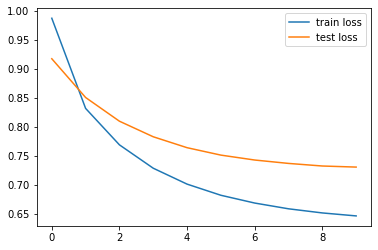

In [43]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

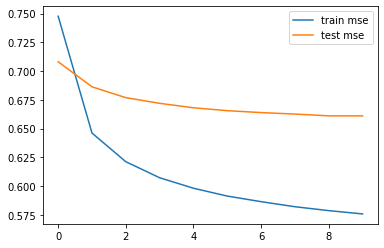

In [44]:
# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()